In [1]:
import matplotlib.pyplot as plt
import numpy as np

import lsst.daf.butler as dB
import lsst.cp.verify.notebooks.utils as utils
import lsst.afw.display as afwDisplay

In [2]:
# This cell should be edited to match the data to be inspected.

# Which calibration type to analyse.
calibType = 'dark'
# Camera
cameraName = 'LATISS'

# Set which display to use.
afwDisplay.setDefaultBackend("astrowidgets")

# Collection name containing the verification outputs.
verifyCollection = 'u/czw/DM-28920/verifyDark.20210707d'
# Collection that the calibration was constructed in.
genCollection = 'u/czw/DM-28920/darkGen.20210707d'

/home/czw/.local/lib/python3.8/site-packages/ginga/cmap.py:13317: MatplotlibDeprecationWarning: The global colormaps dictionary is no longer considered public API.
  for name in _cm.cmap_d:


In [3]:
# Get butler and camera
butler = dB.Butler("/repo/main/", collections=[verifyCollection, genCollection])
camera = butler.get('camera', instrument=cameraName)

In [4]:
# Get Run Statistics
runStats = butler.get('verifyDarkStats', instrument=cameraName)
runSuccess = runStats.pop('SUCCESS')

In [5]:
display = afwDisplay.Display(dims=(1000, 1000))
display.embed()

ImageWidget(children=(Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\x…

In [6]:
# View calibration images:
continueDisplay = True
for detector in camera:
    detectorId = detector.getId()
    calib = butler.get(calibType, instrument=cameraName, detector=detectorId)
    calibArray = calib.getImage().getArray()

    # Get simple stats
    q25, q50, q75 = np.percentile(calibArray.flatten(), [25, 50, 75])
    sigma = 0.74 * (q75 - q25)
    print(f"Detector: {detector.getName()} Median: {q50}   Stdev: {sigma}")

    display.mtv(calib)
    display._scale('linear', (q50 - 3.0 * sigma), (q50 + 3.0* sigma), "")

    continueDisplay, skipNumber = utils.interactiveBlock(f"{calibType} {detector.getName()}", {})
    if continueDisplay is False:
        break

Detector: RXX_S00 Median: 0.008738398551940918   Stdev: 0.056134360190480945
dark RXX_S00 Continue? [c, q, p, #]


In [7]:
# Display summary table of tests and failure counts.
utils.failureTable(runStats)

2021011900151,RXX_S00,1,15,8
2021011900152,RXX_S00,1,14,7
2021011900153,RXX_S00,1,14,7
2021011900154,RXX_S00,1,14,7
2021011900155,RXX_S00,1,14,7
2021011900156,RXX_S00,1,14,7
2021011900157,RXX_S00,1,14,7
2021011900158,RXX_S00,1,14,8
2021011900159,RXX_S00,1,14,8
2021011900160,RXX_S00,1,14,9
2021012100668,RXX_S00,1,3,5


In [16]:
# This block allows the residual images to be scanned for concerns.
blinkResiduals = True
if blinkResiduals:
    continueDisplay = True
    skipNumber = 0
    for exposureId, stats in runStats.items():
        for detector in camera:
            if skipNumber > 0:
                skipNumber -= 1
                continue
        
            detId = detector.getId()
            residual = butler.get('verifyDarkProc', instrument=cameraName, exposure=exposureId, detector=0)
            detStats = butler.get('verifyDarkDetStats', instrument=cameraName, exposure=exposureId, detector=0)
            display.mtv(residual)
            display.scale('linear', 'zscale', None)

            continueDisplay, skipNumber = utils.interactiveBlock(f"{exposureId} {detector.getName()}", detStats)
            if continueDisplay is False:
                break
        if continueDisplay is False:
            break

2021011900151 RXX_S00 Continue? [c, q, p, #]q


/home/czw/dev/DM-28920/cp_verify/python/lsst/cp/verify/notebooks/utils.py:285: UserWarning: FixedFormatter should only be used together with FixedLocator
  # test -> detector -> amp -> list of exposure #


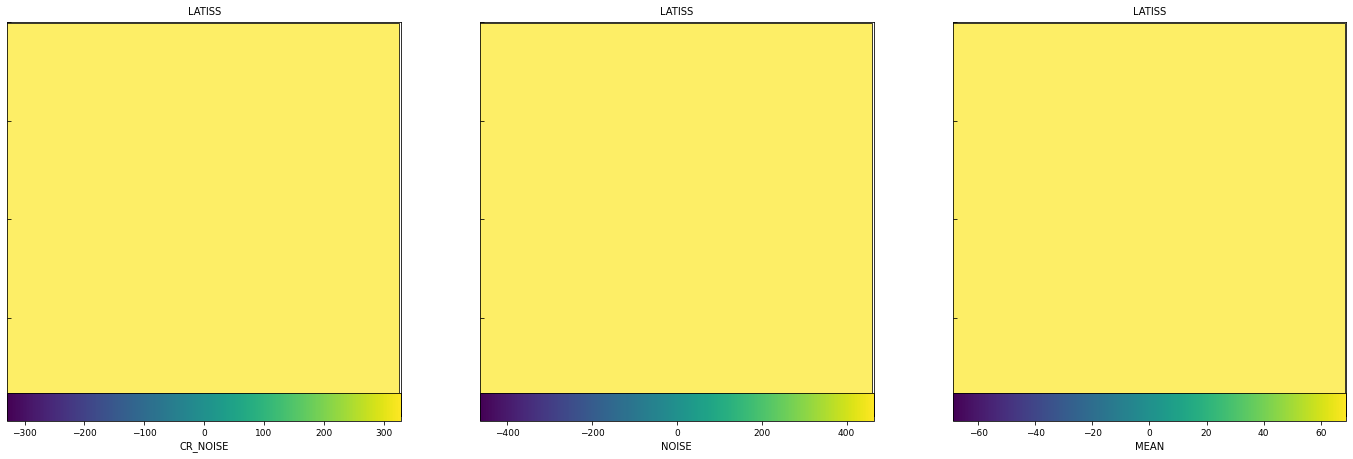

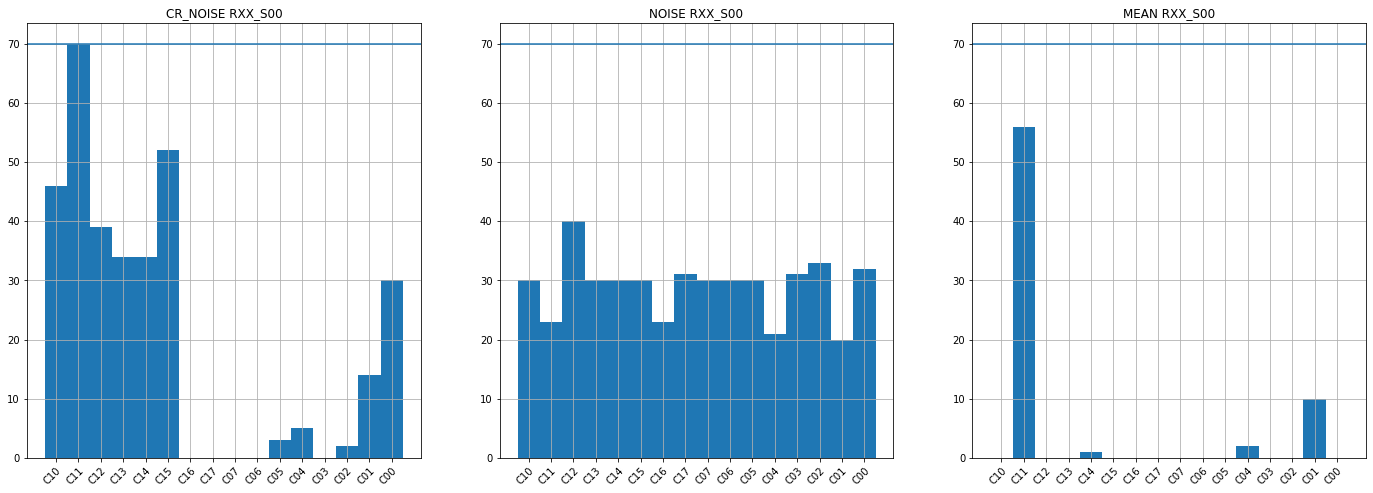

In [10]:
utils.plotFailures(runStats, camera, scaleFactor=8)

In [ ]:
# Additional cells follow here.

In [ ]:
# Get data for mean(darkTime) plot.
ampMeans = {}
for detector in camera:
    ampMeans[detector.getName()] = {}
    for amp in detector.getAmplifiers():
        ampMeans[detector.getName()][amp.getName()] = {'DARKTIME': [], 'MEAN': []}

for exposureId, stats in runStats.items():
    darkTime = next(butler.registry.queryDimensionRecords('exposure', 
                                                          instrument=cameraName, exposure=exposureId)).dark_time
    for detector in camera:
        detId = detector.getId()
        detStats = butler.get('verifyDarkDetStats', instrument=cameraName, exposure=exposureId, detector=detId)
  
        for amp in detector.getAmplifiers():
            mean = detStats['AMP'][amp.getName()]['MEAN']
            ampMeans[detector.getName()][amp.getName()]['DARKTIME'].append(darkTime)
            ampMeans[detector.getName()][amp.getName()]['MEAN'].append(mean)

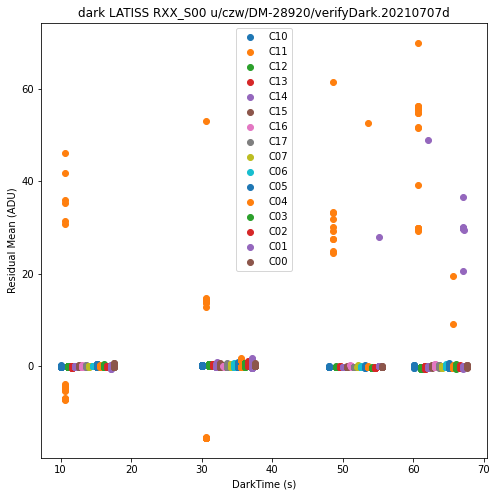

RXX_S00 Continue? [c, q, p, #]


In [17]:
# Plot mean as a function of exposure time, to confirm the residual is flat.
continueDisplay = True
for detector in camera:
    detName = detector.getName()
    horizontalSpace = 0.5
    verticalSpace = 0.0
    plt.figure(figsize=(8, 8))
    for spacer, amp in enumerate(detector.getAmplifiers()):
        plt.scatter(np.array(ampMeans[detName][amp.getName()]['DARKTIME']) + horizontalSpace * spacer,
                    np.array(ampMeans[detName][amp.getName()]['MEAN']) + verticalSpace * spacer,
                    label=amp.getName())
    plt.xlabel("DarkTime (s)")
    plt.ylabel("Residual Mean (ADU)")
    plt.title(f"{calibType} {cameraName} {detName} {verifyCollection}")
    plt.legend()
    plt.show()
    continueDisplay, skipNumber = utils.interactiveBlock(detName, {})
    if continueDisplay is False:
        break